# Python Multithreading vs Multiprocessing Pt2
## An example for Data Scientist (NLP)
## A Text Classifier

This notebook presents how Python multiprocessing and multithreading can accelerate a simple NLP project.
The project consists of a text classifier using a random forest model.

If you are here just to see how multiprocessing and multithreading can be used in a real project, just follow along, you don't really need to know anything about Natural Language Processing to understand this example.

If you get interested by the subject, you should start by studying what [word vectors](https://en.wikipedia.org/wiki/Word_embedding) are. I like [this article](https://medium.com/@jayeshbahire/introduction-to-word-vectors-ea1d4e4b84bf).


In [16]:
import os
import io
import sys
import time
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, as_completed, wait
from sklearn.ensemble import RandomForestClassifier

# used for multithread file processing
def process_vector(line, wordVec_dict, embedding, idx2word):
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    wordVec_dict[word] = vec
    embedding.append(vec)
    idx2word.append(word)

class GloveVectorizer:
    def __init__(self, multithread=False, workers=10):
    # load in pre-trained word vectors
    # which is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
        print('Loading word vectors...')
        wordVec_dict = {}
        embedding = []
        idx2word = []
    
        time_init = time.time()
        if multithread:
            executor = ThreadPoolExecutor(max_workers=workers)
            futures = []
            with zipfile.ZipFile('data/glove.6B.50d.txt.zip') as zf:
                with io.TextIOWrapper(zf.open('glove.6B.50d.txt'), encoding='utf-8', errors='ignore') as f:
                    for line in f:
                        futures.append(executor.submit(process_vector, line, wordVec_dict, embedding, idx2word))
            for future in as_completed(futures):
                pass
        else:   
            with zipfile.ZipFile('data/glove.6B.50d.txt.zip') as zf:
                with io.TextIOWrapper(zf.open('glove.6B.50d.txt'), encoding='utf-8', errors='ignore') as f:
                    for line in f:
                        values = line.split()
                        word = values[0]
                        vec = np.asarray(values[1:], dtype='float32')
                        wordVec_dict[word] = vec
                        embedding.append(vec)
                        idx2word.append(word)
            
        time_end = time.time()
        print(f'Found {len(wordVec_dict)} word vectors in {time_end - time_init}s.')

        self.wordVec_dict = wordVec_dict
        self.embedding = np.array(embedding)
        self.word2idx = {v:k for k,v in enumerate(idx2word)}
        self.V, self.D = self.embedding.shape


    def transform(self, data):
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.lower().split()
            vecs = []
            for word in tokens:
                if word in self.wordVec_dict:
                    vec = self.wordVec_dict[word]
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X


# Hands-on

We will train a text classificator with `scikit-learn` using data provided from Reuters.
The data consists of news texts classified into 8 different labels ([Source](https://www.cs.umb.edu/~smimarog/textmining/datasets/)).

### GloVe Vectorizing

We will use a pre-trained set of [GloVe](https://nlp.stanford.edu/projects/glove/) word vectors.

That's where we can profit from using `multithreading`.
Loading this pre-trained word vector file can take a lot of time. The file is considerably big, and we have to process it line per line. Each line contains a word and then a list of values for each dimension of its word vector.

The GloveVectorizer object loads the pre-trained file.
Let's start by creating with no `multithreading`:

In [ ]:
vectorizer = GloveVectorizer()

Loading word vectors...


That too some time. In a MacBook Air 2019 this was the output from that last cell:
```
Loading word vectors...
Found 400000 word vectors in 269.19898986816406s.
```
Now let's see how much time it takes if we use multithreading (check the `__init__` class code if you are interested in how I've implemented it).

In [17]:
vectorizer = GloveVectorizer(multithread=True)

Loading word vectors...
Found 400000 word vectors in 27.559515953063965s.


Wow. Much faster, right?
In a MacBook Air 2019 this was the output from multithreaded execution:
```
Loading word vectors...
Found 400000 word vectors in 27.559515953063965s.
```

Notice that in this case we could make good use of `multithreading` because the code takes great advantage of async execution.

### Model training and testing

Start by loading the data into dataframes. No need to use multiprocessing nor multithreading here, as reading CSVs into pandas dataframes is stupid fast.

Then we vectorize the train and test data.

In [20]:
train = pd.read_csv('data/r8-train-all-terms.txt', header=None, sep='\t')
test = pd.read_csv('data/r8-test-all-terms.txt', header=None, sep='\t')
train.columns = ['label', 'content']
test.columns = ['label', 'content']

Xtrain = vectorizer.transform(train.content)
Ytrain = train.label
Xtest = vectorizer.transform(test.content)
Ytest = test.label

Numer of samples with no words found: 0 / 5485
Numer of samples with no words found: 0 / 2189


Now the cool part: training and testing.

Luckly for us,`scikit-learn` offers `multiprocessing` nativelly, just by setting it up on the model's parameters.
The following cell will train a same model with the same data using different number of jobs (jobs are mapped to processes in `scikit-learn`).

train score: 0.9992707383773929
test score: 0.9346733668341709
Serial training took 6.164580821990967s.
Multiprocessing training with 2 processes took 3.465038776397705s.
Multiprocessing training with 4 processes took 2.760185956954956s.
Multiprocessing training with 8 processes took 2.872230291366577s.


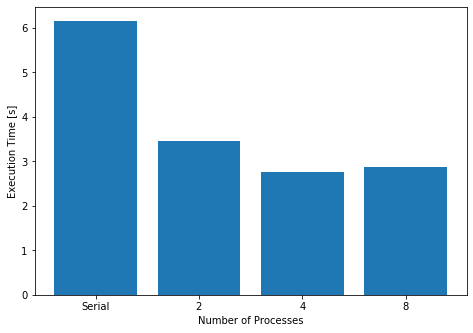

In [19]:
# create the model, train it, print scores
times = []

time_init = time.time()
model = RandomForestClassifier(n_estimators=200)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))
time_end = time.time()
times.append(float(time_end - time_init))
print(f'Serial training took {time_end - time_init}s.')

time_init = time.time()
model = RandomForestClassifier(n_estimators=200, n_jobs=2)
model.fit(Xtrain, Ytrain)
time_end = time.time()
times.append(float(time_end - time_init))
print(f'Multiprocessing training with 2 processes took {time_end - time_init}s.')

time_init = time.time()
model = RandomForestClassifier(n_estimators=200, n_jobs=4)
model.fit(Xtrain, Ytrain)
time_end = time.time()
times.append(float(time_end - time_init))
print(f'Multiprocessing training with 4 processes took {time_end - time_init}s.')

time_init = time.time()
model = RandomForestClassifier(n_estimators=200, n_jobs=8)
model.fit(Xtrain, Ytrain)
time_end = time.time()
times.append(float(time_end - time_init))
print(f'Multiprocessing training with 8 processes took {time_end - time_init}s.')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Processes')
ax.set_ylabel('Execution Time [s]')
num_threads = ['Serial', '2', '4', '8']
ax.bar(num_threads, times)
plt.show()

Well, the image and the timing data speaks by itself. Notice how the speedup stagnates once you reach the number of cores your machine has available (or, of course, a natural plateau).